In [1]:
import numpy as np
import pandas as pd
import six
import tensorflow as tf
import time
import os
from tqdm import tqdm

import random
import string

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_PATH = 'data/pickles/descriptions.pickle'

tf.logging.set_verbosity(tf.logging.INFO)

def transform(txt, pad_to=None):
    # drop any non-ascii characters
    output = np.asarray([ord(c) for c in txt if ord(c) < 255], dtype=np.int32)
    if pad_to is not None:
        output = output[:pad_to]
        output = np.concatenate([
            np.zeros([pad_to - len(txt)], dtype=np.int32),
            output
        ])
    return output

def training_generator(seq_len=100, batch_size=1024):
    """A generator yields (source, target) arrays for training."""
    names_raw, descs_raw = pd.read_pickle(DATA_PATH)
    txt = '\n'.join(descs_raw)

    tf.logging.info('Input text [%d] %s', len(txt), txt[:50])
    source = transform(txt)
    while True:
        offsets = np.random.randint(0, len(source) - seq_len, batch_size)

        # Our model uses sparse crossentropy loss, but Keras requires labels
        # to have the same rank as the input logits.  We add an empty final
        # dimension to account for this.
        yield (
            np.stack([source[idx:idx + seq_len] for idx in offsets]),
            np.expand_dims(
                np.stack([source[idx + 1:idx + seq_len + 1] for idx in offsets]), 
                -1),
        )

six.next(training_generator(seq_len=10, batch_size=1))

INFO:tensorflow:Input text [4733481] Dark garnet in color, the 2013 HALL Napa Valley Ca


(array([[116, 101, 100,  32, 101, 118, 101, 114,  32, 115]]), array([[[101],
         [100],
         [ 32],
         [101],
         [118],
         [101],
         [114],
         [ 32],
         [115],
         [105]]]))

In [3]:
EMBEDDING_DIM = 512

def lstm_model(seq_len=100, batch_size=None, stateful=True):
    """Language model: predict the next word given the current word."""
    source = tf.keras.Input(
        name='seed', shape=(seq_len,), batch_size=batch_size, dtype=tf.int32)

    embedding = tf.keras.layers.Embedding(input_dim=256, output_dim=EMBEDDING_DIM)(source)
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(embedding)
    lstm_2 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(lstm_1)
    #drop_1 = tf.keras.layers.Dropout(0.2)
    predicted_char = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='softmax'))(lstm_2)
    model = tf.keras.Model(inputs=[source], outputs=[predicted_char])
    #model = tf.keras.utils.multi_gpu_model(model, gpus=2)

    model.compile(
        optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
        #optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'])
    return model

tf.keras.backend.clear_session()

training_model = lstm_model(seq_len=100, batch_size=1024, stateful=False)
#training_model.load_weights('model_small_chkpt.h5', by_name=True)

checkpoint = ModelCheckpoint('data/models_weights/model_char_DESCS_chkpt_old.h5', 
                             monitor='sparse_categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
early_stopping = EarlyStopping(monitor='sparse_categorical_accuracy',
                               patience=3,
                               mode='max')
callbacks_list = [checkpoint,early_stopping]

In [4]:
training_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seed (InputLayer)            (1024, 100)               0         
_________________________________________________________________
embedding (Embedding)        (1024, 100, 512)          131072    
_________________________________________________________________
lstm (LSTM)                  (1024, 100, 512)          2099200   
_________________________________________________________________
lstm_1 (LSTM)                (1024, 100, 512)          2099200   
_________________________________________________________________
time_distributed (TimeDistri (1024, 100, 256)          131328    
Total params: 4,460,800
Trainable params: 4,460,800
Non-trainable params: 0
_________________________________________________________________


In [6]:

training_model.load_weights('data/models_weights/model_char_DESCS_chkpt_old.h5')

In [ ]:
# list all data in history
import matplotlib.pyplot as plt

training_acc = training_model.history.history['sparse_categorical_accuracy']
plt.figure(dpi=150)
plt.title("Accuracy per Epoch")
plt.plot(range(len(training_acc)),  training_acc)
plt.show()

## Create BASIC wine DESCRIPTION list

In [23]:
BATCH_SIZE = 5
PREDICT_LEN = 350

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('data/models_weights/model_char_DESCS_chkpt_old.h5')

# We seed the model with our initial string, copied BATCH_SIZE times

seed_txt = 'This wine tastes like '
seed_txt = ''.join(random.choices(string.ascii_uppercase + string.digits, k=20))
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

# Now we can accumulate predictions!
predictions = [seed[:, -1:]]
for i in range(PREDICT_LEN):
    last_word = predictions[-1]
    next_probits = prediction_model.predict(last_word)[:, 0, :]
  
  # sample from our output distribution
    next_idx = [
        np.random.choice(256, p=next_probits[i])
        for i in range(BATCH_SIZE)
    ]
    predictions.append(np.asarray(next_idx, dtype=np.int32))
    
for i in range(BATCH_SIZE):
    print('PREDICTION %d\n\n' % i)
    p = [predictions[j][i] for j in range(PREDICT_LEN)]
    generated = ''.join([chr(c) for c in p])
    print(generated)
    print()
    assert len(generated) == PREDICT_LEN, 'Generated text too short'

PREDICTION 0


Y. The story is best known for its award-winnine experienced from all other vintage Champagne to unfold. As orphorng, Garnacha, Toro, Alivation that connoisseurs, as is the marriage of dried blynd sites, the wine is fruity, there is pleasant flavors of  plum fruits, jammavors, and a tea-leaf as thewine wild strawberry and raspberry flavors with a t

PREDICTION 1


Y. The vineyards are nestled about this Pinot noir and Cabernet Sauvignon and 2001. Laura blend offers complex nuances of apple flavors to a rivetting potential, intense depth and depth together toward almost hillside parcel above the earth and thanks to who introduce bears son, whole cluster (Armanding 200-acre estate located in Clavender, the REE

PREDICTION 2


Y.
This bold Andalt was from his honored tradition and innovation in New Zealand winemaking. Villa naturally in the Napa Valley and intesticing bold growing conditions.

Shrounded by the 92-acre Tigson to whom bust to Napa Valley, and provides the fir

## Create BIG fake wine DESCRIPTION list

In [97]:
seed.shape

(5, 36)

In [107]:
BATCH_SIZE = 1
PREDICT_LEN = 600
N_PREDICTIONS = 100

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('data/models_weights/model_char_DESCS_chkpt_old.h5')

predicted_names = pd.read_csv('data/outputs/NAMES_v1.csv')

fake_DESC = []
for ii in tqdm(range(N_PREDICTIONS)):
    # We seed the model with our initial string, copied BATCH_SIZE times
    #seed_array = np.zeros(shape=(BATCH_SIZE,))
    for i in range(BATCH_SIZE):
        seed_txt = predicted_names['name'][ii+i]
        seed = transform(seed_txt)
        #print(seed.shape)
    seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)
    

    # First, run the seed forward to prime the state of the model.
    prediction_model.reset_states()
    for i in range(len(seed_txt) - 1):
        prediction_model.predict(seed[:, i:i + 1])

    # Now we can accumulate predictions!
    predictions = [seed[:, -1:]]
    for i in range(PREDICT_LEN):
        last_word = predictions[-1]
        next_probits = prediction_model.predict(last_word)[:, 0, :]

      # sample from our output distribution
        next_idx = [
            np.random.choice(256, p=next_probits[i])
            for i in range(BATCH_SIZE)
        ]
        predictions.append(np.asarray(next_idx, dtype=np.int32))

    for i in range(BATCH_SIZE):
        #print('PREDICTION %d\n\n' % i)
        p = [predictions[j][i] for j in range(PREDICT_LEN)]
        generated = ''.join([chr(c) for c in p])
        fake_DESC.append(generated)
        #print(generated)
        #print()
        gen_list = generated.split('.')[1:-1]
        gen_conc = ' '.join(gen_list) + '.'
        fake_DESC.append(gen_conc)
        #print(gen_conc)
        #for item in gen_list:
        #    fake_DESC.append(item.strip()+'.')
        #assert len(generated) == PREDICT_LEN, 'Generated text too short'
pd.DataFrame(fake_DESC, columns=['Description'])\
    .to_csv('data/outputs/DESC_v1_1.csv', index_label=False, index=False, sep='|')



  0%|                                                                       | 0/100 [00:00<?, ?it/s]

  1%|▋                                                              | 1/100 [00:06<10:19,  6.25s/it]

  2%|█▎                                                             | 2/100 [00:07<07:56,  4.86s/it]

  3%|█▉                                                             | 3/100 [00:09<06:17,  3.89s/it]

  4%|██▌                                                            | 4/100 [00:11<05:08,  3.22s/it]

  5%|███▏                                                           | 5/100 [00:12<04:21,  2.75s/it]

  6%|███▊                                                           | 6/100 [00:14<03:49,  2.44s/it]

  7%|████▍                                                          | 7/100 [00:16<03:24,  2.20s/it]

  8%|█████                                                          | 8/100 [00:17<03:07,  2.03s/it]

  9%|█████▋                                                         | 9/100 [00:

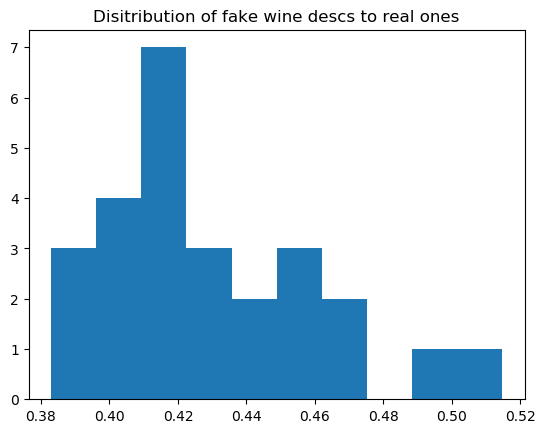

In [45]:
import matplotlib.pyplot as plt
plt.style.use('default')

plt.figure(dpi=100)
plt.title('Disitribution of fake wine descs to real ones')
plt.hist(fake_DESC['Score'])
plt.show()

In [ ]:
from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

real_names, descs_raw = pd.read_pickle(DATA_PATH)
fake_scores = {}
for f_name in tqdm(fake_names):
    max_score = 0.0
    for r_name in descs_raw:
        if similar(f_name,r_name) > max_score:
            max_score = similar(f_name,r_name)
    fake_scores[f_name] = max_score
        

## OLD

In [ ]:
BATCH_SIZE = 5
PREDICT_LEN = 250

# Keras requires the batch size be specified ahead of time for stateful models.
# We use a sequence length of 1, as we will be feeding in one character at a 
# time and predicting the next character.
prediction_model = lstm_model(seq_len=1, batch_size=BATCH_SIZE, stateful=True)
prediction_model.load_weights('/tmp/bard.h5')

# We seed the model with our initial string, copied BATCH_SIZE times

seed_txt = 'Looks it not like the king?  Verily, we must go! '
seed = transform(seed_txt)
seed = np.repeat(np.expand_dims(seed, 0), BATCH_SIZE, axis=0)

# First, run the seed forward to prime the state of the model.
prediction_model.reset_states()
for i in range(len(seed_txt) - 1):
    prediction_model.predict(seed[:, i:i + 1])

# Now we can accumulate predictions!
predictions = [seed[:, -1:]]
for i in range(PREDICT_LEN):
    last_word = predictions[-1]
    next_probits = prediction_model.predict(last_word)[:, 0, :]
  
  # sample from our output distribution
    next_idx = [
        np.random.choice(256, p=next_probits[i])
        for i in range(BATCH_SIZE)
    ]
    predictions.append(np.asarray(next_idx, dtype=np.int32))
    
for i in range(BATCH_SIZE):
    print('PREDICTION %d\n\n' % i)
    p = [predictions[j][i] for j in range(PREDICT_LEN)]
    generated = ''.join([chr(c) for c in p])
    print(generated)
    print()
    assert len(generated) == PREDICT_LEN, 'Generated text too short'